# 1. Teoría

El uso de boostlets o shearlets está basado en la proyección de una imagen en el espacio de Fourier y su descomposición con diferentes filtros que dividen el espacio de Fourier. Estos filtros los llamamos $\hat{\phi}_i$ en Fourier y ${\phi}_i$ en espacio físico. El espacio de Fourier estará por tanto dividido en "p" particiones cada una de ellas correspondiendo a un ${\phi}_i$.  
Todos estos ${\phi}_i$ conforman nuestro diccionario que llamaremos $Sk$.  
Los $\phi_i$ pueden solaparse en distintas zonas del espacio de Fourier.  
+ Lo ideal es que cuando nuestra imagen en Fourier la pasemos por cada uno de estos filtros, la suma de todas esas proyecciones nos de la imagen original de Fourier.
+ La proyección en Fourier de la imagen se define como: $\widehat{\alpha}_i(\omega, k) = \widehat{Im}(\omega, k) .* \widehat{\phi}_i(\omega, k)$
+ Para recobrar la imagen se aplicala operación inversa definida como: $\widehat{Im}^*(\omega, k) = \sum _i \widehat{\alpha}_i(\omega, k) .* \widehat{\phi}_i(\omega, k) = \widehat{Im}(\omega, k) .* \widehat{\phi}^2_i(\omega, k)$ 
+ Para que la imagen Im sea igual que la reconstruida $Im^*$ entonces: 
    - $\widehat{Im}(\omega, k) = \widehat{Im}^*(\omega, k)$    $\rightarrow$  $ \sum _i \widehat{\phi}^2 _i(\omega, k) = 1$





## Imagen objetivo y enmascarada en Fourier

Primero vemos cómo es la imagen original y la imagen enmascarada, que queremos procesar para recuperar la original.

+ Al ser una imagen 2D de numeros reales, al aplicar la transformada 2D de Fourier, se obtienen coeficientes con complejos conjugados con simetría puntual desde el centro (0,0)
  

In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt

from boostlets_mod import Boostlet_syst
from mod_plotting_utilities import plot_array_images, plot_ls_images
from mod_RIRIS_func import load_DB_ZEA, rand_downsamp_RIR, ImageOps, jitter_downsamp_RIR
from mod_RIRIS_func import computePareto, ista, iffst, linear_interpolation_fft, perforMetrics

# Configurar para que todos los labels usen LaTeX
# plt.rcParams.update({
#     'text.usetex': True,            # Usar LaTeX para todo el texto
#     'font.size': 12,                # Tamaño de la fuente general
#     'axes.titlesize': 14,           # Tamaño de los títulos de los ejes
#     'axes.labelsize': 12,           # Tamaño de las etiquetas de los ejes
#     'xtick.labelsize': 10,          # Tamaño de las etiquetas de los ticks del eje x
#     'ytick.labelsize': 10,          # Tamaño de las etiquetas de los ticks del eje y
#     'legend.fontsize': 12,          # Tamaño de la fuente en las leyendas
#     'figure.titlesize': 16,         # Tamaño del título principal de la figura
#     'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
# })
plt.rcParams.update({
    'text.usetex': True,            # Usar LaTeX para todo el texto
    'font.size': 14,                # Tamaño de la fuente general
    'axes.titlesize': 14,           # Tamaño de los títulos de los ejes
    'axes.labelsize': 14,           # Tamaño de las etiquetas de los ejes
    'xtick.labelsize': 14,          # Tamaño de las etiquetas de los ticks del eje x
    'ytick.labelsize': 14,          # Tamaño de las etiquetas de los ticks del eje y
    'legend.fontsize': 14,          # Tamaño de la fuente en las leyendas
    'figure.titlesize': 16,         # Tamaño del título principal de la figura
    'text.latex.preamble': r'\usepackage{amsmath}'  # Permitir usar amsmath en LaTeX
})

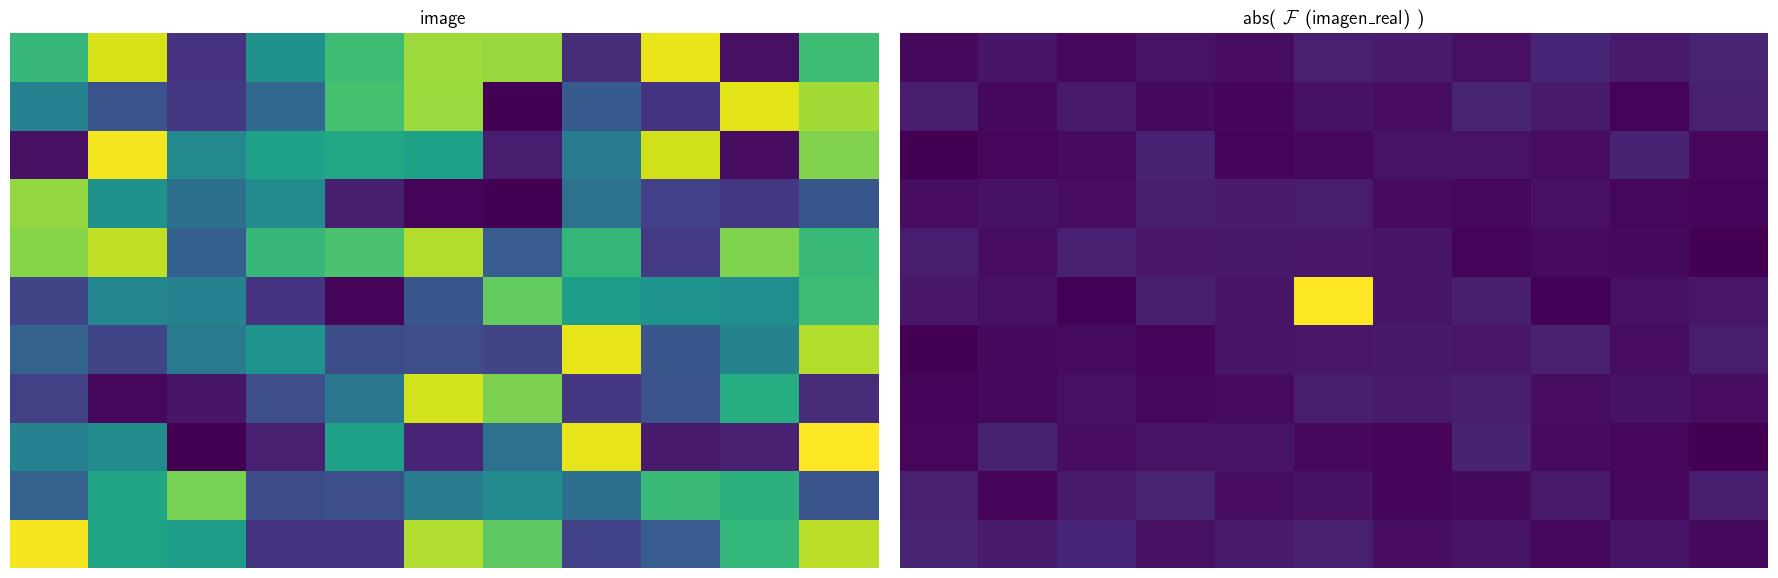

In [3]:
A = np.random.rand(11, 11)
FA = np.fft.fftshift(np.fft.fft2(A))

images = [A, np.abs(FA)]
titles = ["image",  r"abs( $\mathcal{F}$ (imagen_real) )"]
plot_ls_images(images, titles)



In [4]:

ix = 1
iy = 1
c_rows, c_cols = FA.shape
c_rows //= 2 
c_cols //= 2


print("Complex conjugates for points with point symmetry:")
print("----------------------------------------")
print(f"  (+kx, +ky) = {FA[c_rows+iy, c_cols+ix]} ")
print(f"  (-kx, -ky) = {FA[c_rows-iy, c_cols-ix]} ")
print("----------------------------------------")
print(f"  (+kx, -ky) = {FA[c_rows-iy, c_cols+ix]} ")
print(f"  (-kx, +ky) = {FA[c_rows+iy, c_cols-ix]} ")

Complex conjugates for points with point symmetry:
----------------------------------------
  (+kx, +ky) = (2.284168284547763+2.390820168603413j) 
  (-kx, -ky) = (2.284168284547763-2.390820168603413j) 
----------------------------------------
  (+kx, -ky) = (-2.887161014801158-2.4265420260347557j) 
  (-kx, +ky) = (-2.887161014801158+2.4265420260347557j) 


In [5]:
import os
from mod_RIRIS_func import load_sk, load_DB_ZEA, rand_downsamp_RIR, ImageOps, jitter_downsamp_RIR

# Imagen tamaño:
M0, N0 = 100, 100
ratio_mics = 0.5
# ---------- LOAD image ---------------------------
room= 'Balder'
folder = "./dependencies/measurementData"
file = room+"RIR.mat"
file_path = os.path.join(folder, file)

full_image, x, t = load_DB_ZEA(file_path)
x = x.flatten()
dx = x[1]-x[0]

t = t.flatten()
dt = t[1]-t[0]

Tstart1 = 0
Im1 = full_image[Tstart1:Tstart1+M0, :N0]
Tstart2 = 1000
Im2 = full_image[Tstart2:Tstart2+M0, :N0]

mask0, _ = jitter_downsamp_RIR(Im1.shape, ratio_t=1, ratio_x=ratio_mics)
mask1, _ = jitter_downsamp_RIR(Im1.shape, ratio_t=1, ratio_x=ratio_mics/2)



# 2. Efectos de la mascara
El enmascarado de los micrófonos incrementa la energía en bandas horizontales del espectro.
Para el caso de un frente de onda localizado, el cono vertical no está lleno de coeficientes. Se podrían eliminar elementos del diccionario en esa zona.
Para el caso en el que tengo una mezcla de ondas que vienen de todas direcciones, todo el cono vertical está ocupado, por lo que no debería eliminar ningún
elemento que solape con el cono vertical.




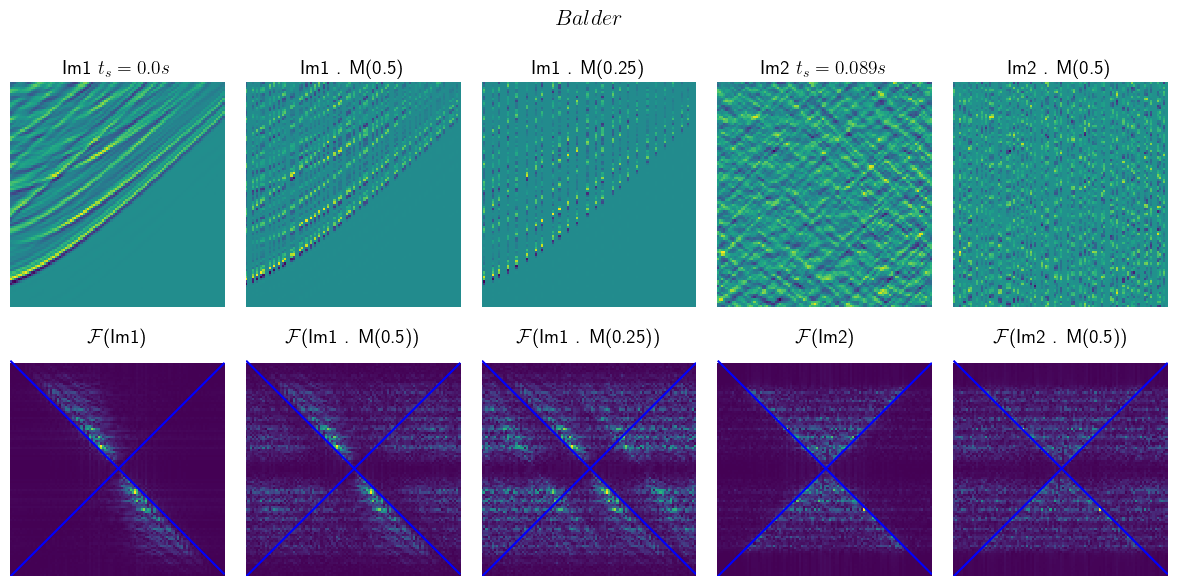

In [6]:

fft1 = np.fft.fftshift( np.fft.fft2(Im1) )
fft2 = np.fft.fftshift( np.fft.fft2(mask0*Im1) )
fft3 = np.fft.fftshift( np.fft.fft2(mask1*Im1) )
fft4 = np.fft.fftshift( np.fft.fft2(Im2) )
fft5 = np.fft.fftshift( np.fft.fft2(mask0*Im2) )

cs = 340
om = np.fft.fftshift( np.fft.fftfreq(n=M0, d=dt) ) # [1/m] , centered freqs
kx = np.fft.fftshift( np.fft.fftfreq(n=N0, d=dx) ) # [1/s] , centered freqs
k = cs * kx # Use for boostlets with symmetrical cones

images = [Im1, mask0*Im1, mask1*Im1, Im2, mask0*Im2, 
          abs(fft1), abs(fft2), abs(fft3), abs(fft4), abs(fft5)]
titles = [rf'Im1 $t_s={Tstart1*dt}s$', 'Im1 . M(0.5)', 'Im1 . M(0.25)', rf'Im2 $t_s={Tstart2*dt:0.3f}s$', 'Im2 . M(0.5)', 
          r'$\mathcal{F}$''(Im1)', r'$\mathcal{F}$''(Im1 . M(0.5))', r'$\mathcal{F}$''(Im1 . M(0.25))', r'$\mathcal{F}$''(Im2)', r'$\mathcal{F}$''(Im2 . M(0.5))']

fig, axs = plt.subplots(2,5, figsize=(12, 6))
for ax, im, titl in zip(axs.flatten(), images, titles):
    # pcol = ax.pcolor(im,linewidth=0,rasterized=True)
    pcol = ax.pcolor(k, om, im, linewidth=0, rasterized=True)
    pcol.set_edgecolor('face')
    ax.set_title(titl)
    ax.axis('off')

for ax, in zip(axs[1,:]):
    ax.plot(k, k, 'b')
    ax.plot(k, -k, 'b')

plt.suptitle(rf"${room}$")
plt.tight_layout()
plt.savefig('./figs_paper/Balder_imgs_masks.eps', format='eps')
plt.show()



Al eliminar más micros se ve el efecto de la convolucion de la máscara y la imagen original. La máscara añade "ruido" en el spectrum con franjas horizontales. Sería interesante eliminar zonas donde podemos relacionar el incremento de energía con el incremento del masking (menos micros) relacionando el spectrum de imagen con una máscara M1 y otra con la máscara con la mitad de micrófonos.

Este approach puede ser interesante, pero eliminaríamos regiones del cono vertical. Para la Im2 eso no es conveniente, por lo que nos limitamos a eliminar elementos del diccionario con soporte en el cono horizontal y así es también más fácil comparar con el  filtro hour-glass o método "lineal". 

# 3. Boostlet teselation

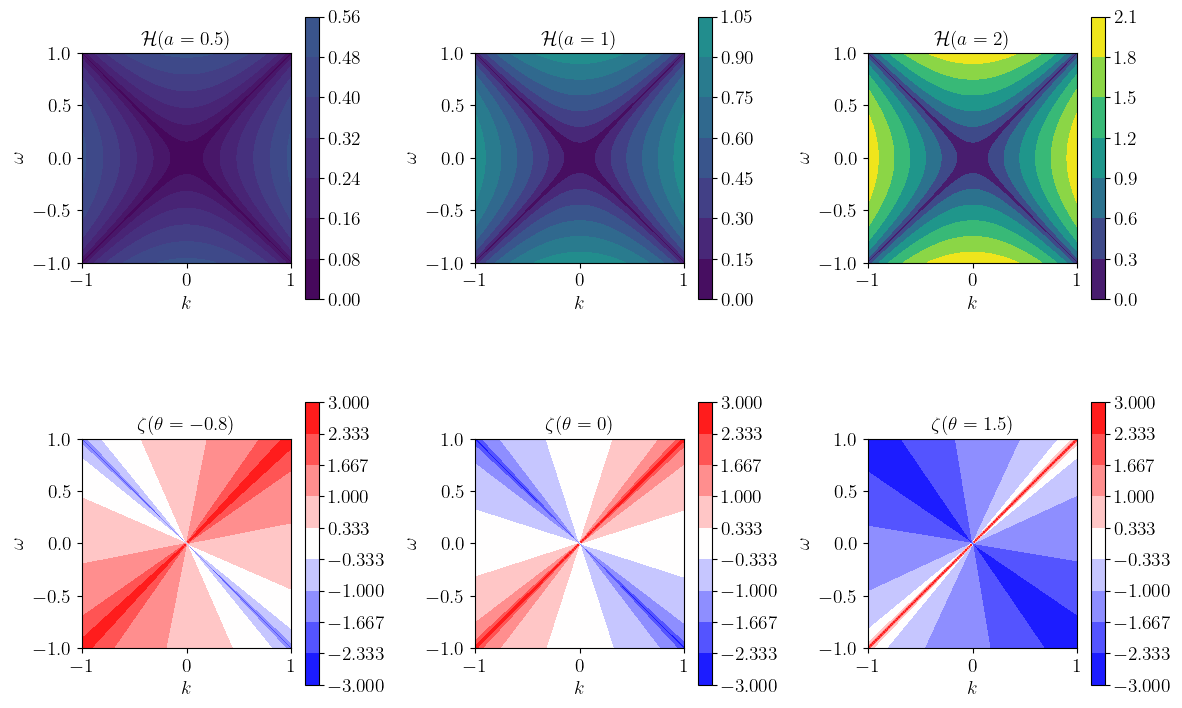

In [7]:
from boostlets_mod import boost_points, diffeo_hor_cone

N=129
om = np.linspace(-1, 1, N)
k = np.linspace(-1, 1, N)
K, OM = np.meshgrid(k, om)

def diffeo(k, om):
    a_v, th_v = diffeo_hor_cone(k=om, om=k)
    a_h, th_h = diffeo_hor_cone(k=k, om=om)
    return a_h + a_v, th_h + th_v

a1 = 2
KB = []
OMB = []
Ad_b = []
Th_b = []
ls_a = [0.5, 1, 2] 
ls_theta = [-0.8, 0, 1.5] 

# Primer bucle: usando thetaj en lugar de un valor fijo para theta
for ai, thetaj in zip(ls_a, ls_theta):
    temp0, temp1 = boost_points(OM, K, a=ai, theta=thetaj)  # Usar thetaj
    KB.append(temp0)
    OMB.append(temp1)

# Segundo bucle: no necesita correcciones, parece correcto
for i in range(len(KB)):
    temp0, temp1 = diffeo(k=KB[i], om=OMB[i])
    # for diagonals
    diag_1 = np.isclose(K, OM, atol=1e-7)
    diag_2 = np.isclose(K, -OM, atol=1e-7)
    temp1[diag_1] = 3 
    temp1[diag_2] = -3
    # For contourf plot regions inf > x > 3  &  -inf < x < -3
    temp1[temp1>3] = 3
    temp1[temp1<-3] = -3
    Ad_b.append(temp0)
    Th_b.append(temp1)


c_levels = np.linspace(-3,3,10)

x_lab = r'$k$'
y_lab = r'$\omega$'

# Crear la figura con subplots, con 2 filas y len(ls_theta) columnas
fig, axs = plt.subplots(2, len(ls_theta), figsize=(4 * len(ls_theta), 8))  # Ajustar tamaño según número de thetas

# Bucle para graficar los resultados en subplots
for i in range(len(ls_theta)):
    # Graficar Ad_b en la fila 1 en función de KB y OMB
    cf1 = axs[0, i].contourf(K, OM, Ad_b[i], cmap='viridis', vmin=0, vmax=2)
    axs[0, i].set_title(rf'$\mathcal{{H}}(a={ls_a[i]})$')
    axs[0, i].set_xlabel(x_lab)
    axs[0, i].set_ylabel(y_lab)
    axs[0, i].set_aspect('equal')
    fig.colorbar(cf1, ax=axs[0, i], shrink=0.8)


    # Graficar Th_b en la fila 2 en función de KB y OMB
    cf2 = axs[1, i].contourf(K, OM, Th_b[i], cmap='bwr', levels=c_levels)
    axs[1, i].set_title(rf'$\zeta (\theta = {ls_theta[i]})$')
    axs[1, i].set_xlabel(x_lab)
    axs[1, i].set_ylabel(y_lab)
    axs[1, i].set_aspect('equal')
    fig.colorbar(cf2, ax=axs[1, i], shrink=0.8)


plt.tight_layout()
plt.savefig('./figs_paper/diffeo_with_boosts.eps', format='eps')
plt.show()

In [8]:
theta=1.5
m = np.tanh(theta)
phi = np.arctan(m)*180/np.pi
print(rf"theta = {theta}, m={m:.4f},  phi = {phi}  ")

theta = 1.5, m=0.9051,  phi = 42.14976456264578  


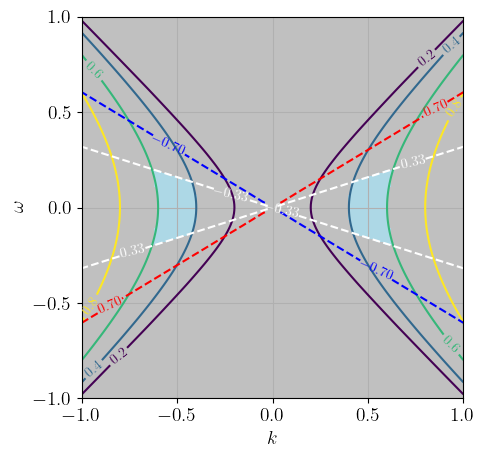

In [79]:
from matplotlib.colors import ListedColormap

# K, OM = np.meshgrid(k, om)
H, Z = diffeo_hor_cone(k=K, om=OM)

coneV = np.abs(OM)>=np.abs(K)  # vertical cone
Z[coneV] = np.nan

Hlevels = np.linspace(0.2, 0.8, 4) # [0.2, 0.4, 0.6, 0.8]
Zlevels = np.array([-0.7, -0.33, 0.33, 0.7])

# Definición de section y filtro
section = np.copy(H)
section[np.abs(H) < 0.4] = 0
section[np.abs(H) > 0.6] = 0
section[np.abs(Z) > 0.33] = 0

# Crear la figura y ejes
fig, ax = plt.subplots()

# Contornos de H y Z
contH = ax.contour(K, OM, H, levels=Hlevels, linestyles='-', cmap='viridis')
Zcolors = ['blue', 'white', 'white', 'red']  # Mismo color 'green' para 0.33 y -0.33
contZ = ax.contour(K, OM, Z, levels=Zlevels, linestyles='--', colors=Zcolors)

# Crear un mapa de colores donde las secciones no válidas sean blancas
# Colorear solo donde section > 0
cmap = ListedColormap(['silver', 'lightblue'])  # Blanco para section <= 0 y color para section > 0
contSection = ax.contourf(K, OM, section > 0, cmap=cmap)

# Etiquetas de contorno
ax.clabel(contH, inline=1, fontsize=10)
ax.clabel(contZ, inline=1, fontsize=10)

ax.grid(True)
ax.set_aspect('equal')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\omega$')
ax.set_xticks([-1.0, -0.5,  0, 0.5, 1.0])
ax.set_yticks([-1.0, -0.5,  0, 0.5, 1.0])


plt.tight_layout()
plt.savefig('./figs_paper/sectionHZ.eps', format='eps')
plt.show()

# Appendix 1

## $\varphi_2$ Func

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


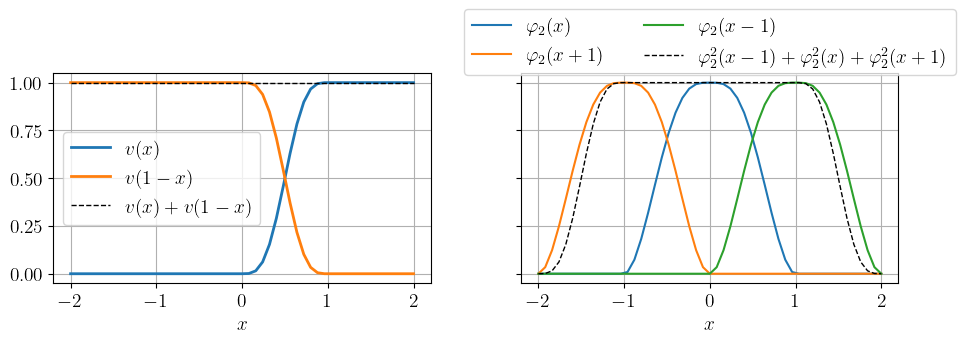

In [78]:
from boostlets_mod import psi_2_fou, meyeraux

x = np.linspace(-2,2,51)

psi2_x = psi_2_fou(x)
psi2_xp1 = psi_2_fou(x+1)
psi2_xm1 = psi_2_fou(x-1)


psi2_2x = psi_2_fou(2*x)

v_x = meyeraux(x)
v_1mx = meyeraux(1.0-x)
v_1px = meyeraux(1.0+x)

i = -1
fig, axs = plt.subplots(1, 2, figsize=(10,4))

i +=1
ax = axs.flatten()[i]
ax.plot(x, v_x, label=r'$v(x)$', linewidth=2)
ax.plot(x, v_1mx, label=r'$v(1-x)$', linewidth=2)
ax.plot(x, v_x + v_1mx, '--k', label=r'$v(x)+v(1-x)$', linewidth=1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel(r'$x$')
ax.legend()
# ax.set_title(r"Auxiliary Meyer Function $v(x)$ \\ and bump function $\varphi_2(x) = \sqrt{{1-|x|}}$")
ax.grid(True)

i +=1
ax = axs.flatten()[i]
ax.plot(x, psi2_x, label=r'$\varphi_2(x)$')
ax.plot(x, psi2_xp1, label=r'$\varphi_2(x+1)$')
ax.plot(x, psi2_xm1, label=r'$\varphi_2(x-1)$')
ax.plot(x, psi2_x**2+psi2_xp1**2+psi2_xm1**2, '--k', label=r'$\varphi_2^2(x-1)+\varphi_2^2(x)+\varphi_2^2(x+1)$', linewidth=1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel(r'$x$')
ax.set_yticklabels([])
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
# ax.legend(loc='best', bbox_to_anchor=(0.8, 0.8), ncol=1)

plt.tight_layout()
plt.savefig('./figs_paper/meyeraux_and_bump.eps', format='eps')
plt.show()

## Wavelet $\varphi_1$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


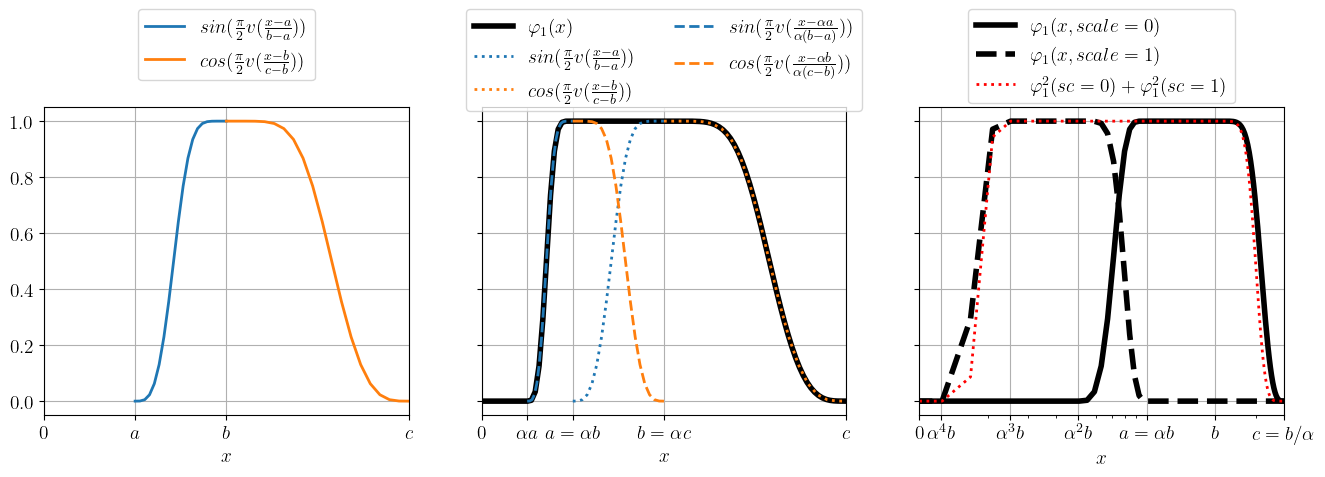

In [16]:
from boostlets_mod import Meyer_system

a, b, c = 1, 2, 4
alpha = a/b
a1, b1, c1 = [alpha * val for val in (a, b, c)]
a2, b2, c2 = [alpha**2 * val for val in (a, b, c)]
a3, b3, c3 = [alpha**3 * val for val in (a, b, c)]


x = np.linspace(-4.2, 4.2, 201)
abs_x = np.abs(x)

MS = Meyer_system(b, alpha)
psi1_0 = MS.psi_1(x, 0)
psi1_1 = MS.psi_1(x, 1)


segm_ab = np.linspace(a,b,20)
segm_bc = np.linspace(b,c,20)
segm_ab_1 = np.linspace(a1,b1,20)
segm_bc_1 = np.linspace(b1,c1,20)
# segm_ab_2 = np.linspace(a2,b2,20)
# segm_bc_2 = np.linspace(b2,c2,20)
# segm_ab_3 = np.linspace(a3,b3,20)
# segm_bc_3 = np.linspace(b3,c3,20)


sin_ab = np.sin(np.pi/2 * meyeraux((segm_ab - a)/(b-a)))
cos_bc = np.cos(np.pi/2 * meyeraux((segm_bc - b)/(c-b)))
sin_ab_1 = np.sin(np.pi/2 * meyeraux((segm_ab_1 - a1)/(b1-a1)))
cos_bc_1 = np.cos(np.pi/2 * meyeraux((segm_bc_1 - b1)/(c1-b1)))
# sin_ab_2 = np.sin(np.pi/2 * meyeraux((segm_ab_2 - a2)/(b2-a2)))
# cos_bc_2 = np.cos(np.pi/2 * meyeraux((segm_bc_2 - b2)/(c2-b2)))
# sin_ab_3 = np.sin(np.pi/2 * meyeraux((segm_ab_3 - a3)/(b3-a3)))
# cos_bc_3 = np.cos(np.pi/2 * meyeraux((segm_bc_3 - b3)/(c3-b3)))

i = -1
fig, axs = plt.subplots(1, 3, figsize=(16,4))

# -------------------------- PLOT 1 ----------------------------------------------------
i +=1
ax = axs.flatten()[i]
ax.plot(segm_ab, sin_ab, label=r'$sin(\frac{\pi}{2}v(\frac{x-a}{b-a}))$', linewidth=2)
ax.plot(segm_bc, cos_bc, label=r'$cos(\frac{\pi}{2}v(\frac{x-b}{c-b}))$', linewidth=2)
ax.set_xlim([0, c])
ax.set_xticks([0, a, b, c])
ax.set_xticklabels([r"$0$", r"$a$", r"$b$", r"$c$"])
ax.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=1)
ax.set_xlabel(r'$x$')

# -------------------------- PLOT 2 ----------------------------------------------------
i +=1
ax = axs.flatten()[i]
# Primeros plots y guardar colores
pl4 = ax.plot(x, psi1_0, '-', label=r'$\varphi_1(x)$', linewidth=4, color='k')

pl0 = ax.plot(segm_ab, sin_ab, ':', label=r'$sin(\frac{\pi}{2}v(\frac{x-a}{b-a}))$', linewidth=2)
pl1 = ax.plot(segm_bc, cos_bc, ':', label=r'$cos(\frac{\pi}{2}v(\frac{x-b}{c-b}))$', linewidth=2)
col0 = pl0[0].get_color()  # Obtener el color de la primera línea
col1 = pl1[0].get_color()  # Obtener el color de la segunda línea
# Plots adicionales con los colores guardados
pl2 = ax.plot(segm_ab_1, sin_ab_1, '--', label=r'$sin(\frac{\pi}{2}v(\frac{x-\alpha a}{\alpha(b-a)}))$', linewidth=2, color=col0)
pl3 = ax.plot(segm_bc_1, cos_bc_1, '--', label=r'$cos(\frac{\pi}{2}v(\frac{x-\alpha b}{\alpha(c-b)}))$', linewidth=2, color=col1)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
# Configuración de ejes
ax.set_xlim([0, c])
ax.set_xticks([0, a1, a, b, c])
ax.set_xticklabels([r"$0$", r"$\alpha a$", r"$a=\alpha b$", r"$b=\alpha c$", r"$c$"])
ax.grid(True)
ax.set_yticklabels([])
ax.set_xlabel(r'$x$')

# -------------------------- PLOT 3 ----------------------------------------------------
i +=1
ax = axs.flatten()[i]

# Primeros plots y guardar colores
pl0 = ax.plot(x, psi1_0, '-', label=r'$\varphi_1(x, scale=0)$', linewidth=4, color='k')
pl1 = ax.plot(x, psi1_1, '--', label=r'$\varphi_1(x, scale=1)$', linewidth=4, color='k')
pl2 = ax.plot(x, psi1_0**2 + psi1_1**2, ':', label=r'$\varphi_1^2(sc=0)+\varphi_1^2(sc=1)$', linewidth=2, color='r')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=1)

# Configuración de ejes
ax.set_xscale('log')
ax.set_xlim([1e-1, c])
ax.set_xticks([1e-1, a3, a2, a1, a, b, c])
ax.set_xticklabels([r"$0$", r"$\alpha^4 b$", r"$\alpha^3 b$", r"$\alpha^2 b$", r"$a=\alpha b$", r"$b$", r"$c=b/\alpha$"])
ax.grid(True)
ax.set_yticklabels([])
ax.set_xlabel(r'$x$')

# plt.tight_layout()
plt.savefig('./figs_paper/meyerhelper_and_varphi1.eps', format='eps')
plt.show()

# Boostlet



## Dicc boostlet (no-Parseval)

El metodo ISTA es un metodo recursivo, por lo que puede ser interesante ver cómo afecta la recursividad en las proyecciones con el diccionario.  
La funcion alphas = ffst(image, Sk) obtiene los coeficientes en físico (alphas), resultado de proyectar la imagen (image) en el diccionario (Sk) de funciones ($\phi_i$).  
La funcion rec_image = iffst(alphas, Sk), obtiene la imagen (rec_image) recobrada de los coeficientes (alphas) y el diccionario Sk.  
+ En esta proyeccion image -> alphas -> rec_image, si el diccionario no es de Parseval, la reconstrucción no sera perfecta. 
    - Al usar un metodo iterativo que proyectara multiples veces la imagen, podemos diverger debido a que el dicc no es de tipo Parseval.



- Cargar imagen e imagen con pad y sus respectivos diccionarios Sk

In [9]:
from mod_RIRIS_func import load_sk, ffst, iffst, ImageOps

Tstart = 0
image = full_image[Tstart:Tstart+100, :N0]
extr_size = (128,128)
extrap_mode = 'pad'
imOps = ImageOps(image.shape, mask=np.ones(image.shape[1]), extrap_shape=extr_size, mode=extrap_mode) 
image_ext = imOps.expand_image(image)

S, n_thetas = 1, 5

build_dict = dict(Sk_type = 'boostlet', N = image.shape[0], S = S, n_thetas = n_thetas)
Sk = load_sk(folder='./', file='dummy', build_dict=build_dict)

build_dict = dict(Sk_type = 'boostlet', N = image_ext.shape[0], S = S, n_thetas = n_thetas)
Sk_ext = load_sk(folder='./', file='dummy', build_dict=build_dict)



Generating boostlet dictionary. N=100, S=1, n_thetas=5
Generating boostlet dictionary. N=128, S=1, n_thetas=5


+ Funcion para proyectar y recobrar la imagen

In [10]:
def proyection(image, Sk):
    alf = ffst(image, Sk)
    rec_im = iffst(alf, Sk)
    return rec_im


- Resultados recursion para imagen sin pad

In [11]:
max_iter = 50
rec_im = proyection(image, Sk) 
images = [image, rec_im]
for i in range(max_iter):
    dif_image = image-rec_im
    resid = np.linalg.norm(dif_image, 2)
    print(f" iter {i}/{max_iter}.  Residue: {resid}")

    rec_im = proyection(rec_im, Sk)
    images.append(rec_im)

dif_image = image-rec_im
resid = np.linalg.norm(dif_image, 2)
print(f" iter {max_iter}/{max_iter}.  Residue: {resid}")

# images = np.fft.fftshift( np.fft.fft2(images, axes=(0,1)), axes=(0,1) )
# plot_array_images(array=images, num_cols=5, cmap='gray')


 iter 0/50.  Residue: 1.6181228424117247
 iter 1/50.  Residue: 4.57268966599968
 iter 2/50.  Residue: 10.009640907897548
 iter 3/50.  Residue: 20.065379736701598
 iter 4/50.  Residue: 38.72819235761791
 iter 5/50.  Residue: 73.4540010999565
 iter 6/50.  Residue: 138.20028407137877
 iter 7/50.  Residue: 259.128158912045
 iter 8/50.  Residue: 485.3280449130472
 iter 9/50.  Residue: 909.0100094946256
 iter 10/50.  Residue: 1703.5369297489965
 iter 11/50.  Residue: 3195.1133757739262
 iter 12/50.  Residue: 5997.988590777134
 iter 13/50.  Residue: 11269.575534976637
 iter 14/50.  Residue: 21192.067405333797
 iter 15/50.  Residue: 39882.0237258836
 iter 16/50.  Residue: 75108.8892178497
 iter 17/50.  Residue: 141543.0145321253
 iter 18/50.  Residue: 266896.4540274285
 iter 19/50.  Residue: 503536.415194668
 iter 20/50.  Residue: 950454.6611697937
 iter 21/50.  Residue: 1794838.1832583637
 iter 22/50.  Residue: 3390748.3773396243
 iter 23/50.  Residue: 6408067.267059439
 iter 24/50.  Residue:

In [12]:
ims = [im-images[0] for im in images]
ims_arr = np.stack(ims, axis=2)

d_fft_ims = np.abs( np.fft.fftshift( np.fft.fft2(ims_arr, axes=(0,1)), axes=(0,1) ) )



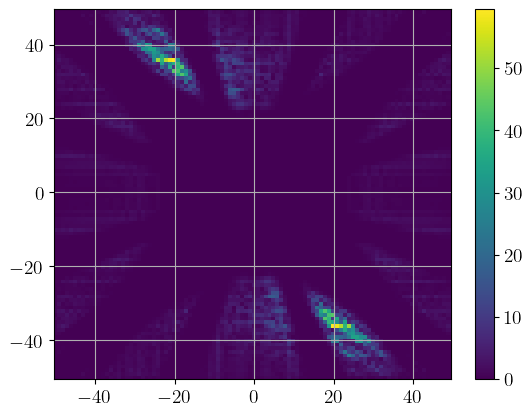

In [13]:
nx = ims_arr.shape[1]
ny = ims_arr.shape[0]

xax = np.arange(nx) - (nx//2)
yax = np.arange(ny) - (ny//2)

id = 1
fig, ax = plt.subplots(1,1)
c1 = ax.pcolor(xax, yax, d_fft_ims[:,:,id])
ax.grid('on')

# ax[0].pcolor(xax, yax, d_fft_ims[:,:,id])
# # ax.pcolor(ims_arr[:,:,id])
# ax[0].grid('on')
# ax[1].pcolor(xax, yax, np.abs(Sk[:,:,id]))
# ax[1].grid('on')

plt.colorbar(c1)
plt.show()


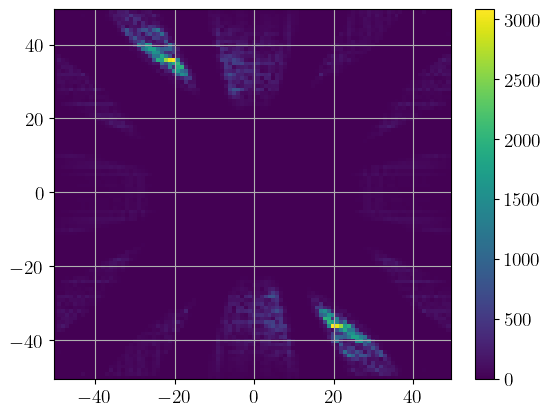

[-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49]


In [14]:
nx = ims_arr.shape[1]
ny = ims_arr.shape[0]

xax = np.arange(nx) - (nx//2)
yax = np.arange(ny) - (ny//2)

id = 6
fig, ax = plt.subplots(1,1)
c1 = ax.pcolor(xax, yax, d_fft_ims[:,:,id])
ax.grid('on')

# ax[0].pcolor(xax, yax, d_fft_ims[:,:,id])
# # ax.pcolor(ims_arr[:,:,id])
# ax[0].grid('on')
# ax[1].pcolor(xax, yax, np.abs(Sk[:,:,id]))
# ax[1].grid('on')

plt.colorbar(c1)
plt.show()

print(xax)

- resultados recursion para imagen con pad

In [15]:
max_iter = 50
rec_im = proyection(image_ext, Sk_ext)

images = [image_ext, rec_im]
for i in range(max_iter):
    dif_image = image_ext-rec_im
    resid = np.linalg.norm(dif_image, 2)
    print(f" iter {i}/{max_iter}.  Residue: {resid}")

    rec_im = proyection(rec_im, Sk_ext)
    images.append(rec_im)

dif_image = image_ext-rec_im
resid = np.linalg.norm(dif_image, 2)
print(f" iter {max_iter}/{max_iter}.  Residue: {resid}")

# plot_array_images(array=images, num_cols=5)

 iter 0/50.  Residue: 1.6334442104192388
 iter 1/50.  Residue: 4.626182152448606
 iter 2/50.  Residue: 10.149125274044911
 iter 3/50.  Residue: 20.390385418208012
 iter 4/50.  Residue: 39.444528413807205
 iter 5/50.  Residue: 74.98398708076542
 iter 6/50.  Residue: 141.40347156824495
 iter 7/50.  Residue: 265.74020252013145
 iter 8/50.  Residue: 498.8284206230705
 iter 9/50.  Residue: 936.3297754433554
 iter 10/50.  Residue: 1758.4071249934566
 iter 11/50.  Residue: 3304.6097688613927
 iter 12/50.  Residue: 6215.290877794895
 iter 13/50.  Residue: 11698.788041475853
 iter 14/50.  Residue: 22036.415630084357
 iter 15/50.  Residue: 41537.298417771875
 iter 16/50.  Residue: 78344.38114225437
 iter 17/50.  Residue: 147851.46667311122
 iter 18/50.  Residue: 279170.2679793604
 iter 19/50.  Residue: 527373.1879027539
 iter 20/50.  Residue: 996675.9287406808
 iter 21/50.  Residue: 1884345.6805855378
 iter 22/50.  Residue: 3563881.8506468385
 iter 23/50.  Residue: 6742627.4978997335
 iter 24/50